## Week 6: Chọn ít nhất 2 trong 4 bộ dữ liệu sau để xây dựng mô hình classification
Yêu cầu:
- Nếu bạn chọn bộ car, target là cột mpg (miles per gallon).
- Với 3 bộ dữ liệu còn lại, hãy đọc phần hướng dẫn tương ứng. Chú ý với
bộ csgo, hãy nghĩ xem có cần thiết phải dùng toàn bộ các feature hay không? Nếu không thì hãy loại bỏ feature bạn thấy không cần thiết. Chú ý là với dataset này thì dự đoán thắng thua quan trọng hơn là dự đoán hòa

In [145]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

from ydata_profiling import ProfileReport

# Diabetes Classification

In [79]:
df = pd.read_csv('diabetes_data.csv')

In [80]:
# profile = ProfileReport(df,title="Diabetes Data", explorative=True)
# profile.to_file('diabetes.html')

In [81]:
x = df.drop('DiabeticClass', axis=1, inplace=False)
y = df['DiabeticClass']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=200)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

categorical_features = x_train.columns.tolist()
categorical_features.remove('Age')

other_order = [['No', 'Yes']] * (len(categorical_features) - 1)
gender_order = ['Male', 'Female']
ord_transformer = OrdinalEncoder(categories=[gender_order] + other_order)

preprocessor = ColumnTransformer(transformers=[
    ('encoder', ord_transformer, categorical_features),
],remainder='passthrough')

param = {
    "classifier__n_estimators": [20, 50, 100, 200],
    "classifier__criterion": ["gini", "entropy", "log_loss"],
    "classifier__max_depth": [None, 2, 5, 10]
}

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=200))
])

model_gr = GridSearchCV(estimator=model, param_grid=param,scoring='recall', cv=5, verbose=2)

In [82]:
model_gr.fit(x_train, y_train)
print("Best parameters: {}".format(model_gr.best_params_))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=20; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__criterion=gin

In [83]:
y_pred = model_gr.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        41
           1       0.97      0.98      0.98        63

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104



# Stroke Classification

In [84]:
df = pd.read_csv('stroke_classification.csv')
df.head()

,pat_id,stroke,gender,age,hypertension,heart_disease,work_related_stress,urban_residence,avg_glucose_level,bmi,smokes
0,1,1,Male,67.0,0,1,0,1,228.69,36.6,1
1,2,1,Female,61.0,0,0,1,0,202.21,NaN,0
2,3,1,Male,80.0,0,1,0,0,105.92,32.5,0
3,4,1,Female,49.0,0,0,0,1,171.23,34.4,1
4,5,1,Female,79.0,1,0,1,0,174.12,24.0,0


In [85]:
# profile_report = ProfileReport(df, title="Stoke Report", explorative=True)
# profile_report.to_file("stroke.html")

### Preprocessing:
- Bỏ 1 observation có gender = 1 
- Thay thế giá trị bị khuyết tại cột bmi

- Balance target class 'Stroke' bằng cách Oversampling

In [119]:
df = df[df['gender'] != 'Other']

In [127]:
x = df.drop(['stroke','pat_id'],axis=1,inplace=False)
y = df['stroke']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=200)

num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ("scaler",StandardScaler())
])

gender_order =['Male', 'Female']
ord_transformer = OrdinalEncoder(categories=[gender_order])

preprocessor = ColumnTransformer(transformers=[
    ('imputer', num_transformer, ['bmi','age','avg_glucose_level']),
    ('encoder', ord_transformer, ['gender'])
],remainder='passthrough')

param = {
    "n_estimators": [20, 50, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [None]
}

model_gr = GridSearchCV(estimator=RandomForestClassifier(random_state=200), param_grid=param,scoring='recall', cv=5, verbose=2)

In [128]:
x_train = preprocessor.fit_transform(x_train)

smote = SMOTE(random_state=200)
x_train_balanced,y_train_balanced = smote.fit_resample(x_train,y_train)

print(y_train.value_counts())
print(y_train_balanced.value_counts())

stroke
0    3885
1     202
Name: count, dtype: int64
stroke
0    3885
1    3885
Name: count, dtype: int64


In [129]:
model_gr.fit(x_train_balanced,y_train_balanced)
print("Best parameters: {}".format(model_gr.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ....criterion=gini, max_depth=None, n_estimators=20; total time=   0.1s
[CV] END ....criterion=gini, max_depth=None, n_estimators=20; total time=   0.1s
[CV] END ....criterion=gini, max_depth=None, n_estimators=20; total time=   0.1s
[CV] END ....criterion=gini, max_depth=None, n_estimators=20; total time=   0.1s
[CV] END ....criterion=gini, max_depth=None, n_estimators=20; total time=   0.1s
[CV] END ....criterion=gini, max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....criterion=gini, max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....criterion=gini, max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....criterion=gini, max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....criterion=gini, max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ...criterion=gini, max_depth=None, n_estimators=100; total time=   0.5s
[CV] END ...criterion=gini, max_depth=None, n_est

In [130]:
x_test = preprocessor.transform(x_test)
y_pred = model_gr.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       975
           1       0.13      0.15      0.14        47

    accuracy                           0.91      1022
   macro avg       0.54      0.55      0.55      1022
weighted avg       0.92      0.91      0.92      1022



In [135]:
model = LogisticRegression()
model.fit(x_train_balanced, y_train_balanced)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       975
           1       0.13      0.87      0.23        47

    accuracy                           0.74      1022
   macro avg       0.56      0.80      0.54      1022
weighted avg       0.95      0.74      0.81      1022



In [143]:
param = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "poly"],
    "gamma": ['scale', 'auto']
}
svm_model = SVC(probability=True, random_state=200)
model_gr = GridSearchCV(estimator=svm_model, param_grid=param,scoring='recall', cv=5, verbose=2)

model_gr.fit(x_train_balanced, y_train_balanced)
print("Best parameters: {}".format(model_gr.best_params_))

y_pred = model_gr.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.4s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.4s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.4s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.4s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.2s
[CV] END ...................C=0.1, gamma=auto, k

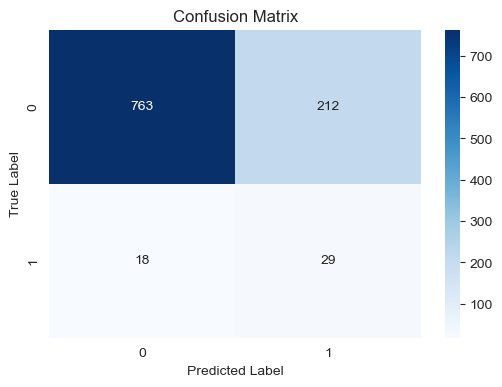

In [146]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()